# 02 - Latent Semantic Analysis (LSA)
This notebook performs Latent Semantic Analysis on the governance data set. It assumes the data was cleaned and placed in the cache by the "_00 - Preprocess the Governance Data Set__" notebook.

The code in this notebook is largely based on the [Introduction to Latent Semantic Analysis](https://www.youtube.com/playlist?list=PLroeQp1c-t3qwyrsq66tBxfR6iX6kSslt) youtube series by Joshua Cook.


---
## Dependencies and Imports
Here we import the libraries we need to perform our analysis.

In [1]:
!pip install scikit-learn pandas seaborn graphviz

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
CMAP_VLAG = sns.color_palette("vlag", as_cmap=True)
print(f"seaborn=={sns.__version__}")

from graphviz import __version__ as graphviz__version__
print(f"graphviz=={graphviz__version__}")
from graphviz import Source as dot_graph

import numpy as np
print(f"numpy=={np.__version__}")


python==3.11.4
scikit-learn==1.2.2
pandas==2.0.2
matplotlib==3.7.1
seaborn==0.12.2
graphviz==0.20.1
numpy==1.25.0


---
## Process Steps
The image below shows the process steps that we are taking in this notebook. The values for `min_df` and `max_df` are explained elsewhere.

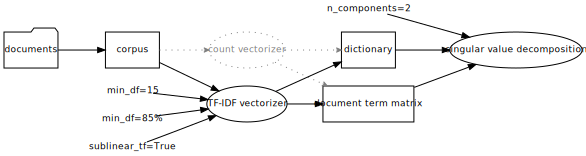

In [3]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer", color=grey fontcolor=grey style=dotted];
      tfidf [label="TF-IDF vectorizer"]; svd [label="singular value decomposition"];
  node [shape=plain]; min_df [label="min_df=15"]; max_df [label="min_df=85%"];
      sublinear_tf [label="sublinear_tf=True"]; n_components [label="n_components=2"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  corpus -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  corpus -> tfidf;
  sublinear_tf -> tfidf;
  min_df -> tfidf;
  max_df -> tfidf;
  vec -> dtm [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dtm;
  vec -> dict [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dict;
  dtm -> svd;
  dict -> svd;
  n_components -> svd;
}
''')

In [4]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df, max_df, sublinear_tf):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary

def perform_lsa(dt_matrix, dictionary, n_components):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(dt_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T

def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()


---
## Apply LSA to the Governance Data Set
We apply LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set.

### Load the DV Documents from the Governance Data

In [5]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [6]:
MIN_DF = 15   # count
MAX_DF = 0.85 # percent
SUBLINEAR_TF = True


In [7]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [8]:
corpus.info()


<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, GM0003DV02 to GM1987DV01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    245 non-null    string
dtypes: string(1)
memory usage: 3.8+ KB


In [9]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
document_term_matrix


,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuidoost,zuinig,zuiniger,zuiveren,zuivering,zwaar,zwart,zwembad,zwerfafval,zwerfvuil
GM0003DV02,0.00000,0.011961,0.000000,0.000000,0.000000,0.038088,0.029612,0.0,0.0,0.012241,...,0.0,0.032091,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GM0005DV01,0.00000,0.014458,0.000000,0.000000,0.000000,0.000000,0.012821,0.0,0.0,0.000000,...,0.0,0.025169,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091655,0.000000
GM0007DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017467,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.015561,0.000000,0.000000,0.037044,0.049653
GM0009DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018100,0.0,0.0,0.035368,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.033804,0.000000,0.000000
GM0034DV01,0.00000,0.015308,0.028343,0.000000,0.000000,0.000000,0.013575,0.0,0.0,0.000000,...,0.0,0.015739,0.0,0.000000,0.031880,0.034670,0.036210,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.00000,0.022688,0.017603,0.026454,0.045707,0.000000,0.014275,0.0,0.0,0.000000,...,0.0,0.016551,0.0,0.033125,0.000000,0.021533,0.000000,0.000000,0.000000,0.000000
GM1955DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022652,0.0,0.0,0.015440,...,0.0,0.000000,0.0,0.000000,0.000000,0.048157,0.000000,0.000000,0.000000,0.000000
GM1955DV02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.026038,...,0.0,0.026160,0.0,0.000000,0.000000,0.000000,0.060182,0.000000,0.000000,0.000000
GM1955DV03,0.00000,0.000000,0.000000,0.000000,0.000000,0.084665,0.013597,0.0,0.0,0.015692,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
dictionary

array(['aanbested', 'aanbesteding', 'aanbestedingen', ..., 'zwembad',
       'zwerfafval', 'zwerfvuil'], dtype=object)

In [11]:
topic_encodings, encoding_matrix = perform_lsa(document_term_matrix, dictionary, 2)
topic_encodings


,topic 0,topic 1
GM0003DV02,0.566258,-0.088309
GM0005DV01,0.514658,0.357787
GM0007DV01,0.542931,0.367697
GM0009DV01,0.454025,-0.103823
GM0034DV01,0.484799,-0.053682
...,...,...
GM1945DV01,0.626101,-0.037351
GM1955DV01,0.469120,0.359916
GM1955DV02,0.404564,-0.091647
GM1955DV03,0.504876,-0.091572


In [12]:
encoding_matrix


,topic 0,topic 1
aanbested,0.014110,-0.009754
aanbesteding,0.024423,0.000802
aanbestedingen,0.009246,-0.001437
aanbestedingsbeleid,0.011459,-0.006624
aanbestedingstraject,0.005343,0.001846
...,...,...
zwaar,0.015062,0.016458
zwart,0.005122,-0.005599
zwembad,0.012588,-0.009689
zwerfafval,0.020227,0.045383


In [13]:
n_most_significant("topic 0", 20, encoding_matrix)


,topic 0
eur,0.049944
afval,0.049168
maatschappelijk,0.046794
water,0.046491
wij,0.045539
programma,0.045537
natuur,0.045243
mobiliteit,0.044971
ruimtelijk,0.044866
communicatie,0.044820


In [14]:
n_most_significant("topic 1", 20, encoding_matrix)


,topic 1
gevaarlijk,0.101736
geluid,0.091743
melding,0.088093
milieutak,0.085925
veiligheid,0.084878
omgevingsvergunning,0.080944
bodemkwaliteit,0.080093
wabo,0.079279
milieubeleidsplan,0.078200
milieubeleid,0.076553


### Determine the correct number of topics using latent sementic analysis
Explained variance based on https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

In [15]:
performance = []
test = range(1, 255)

for n in test: #removed the loop for reasons of performance
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(document_term_matrix)
    performance.append(lsa.explained_variance_.sum())


(1.0, 255.0)

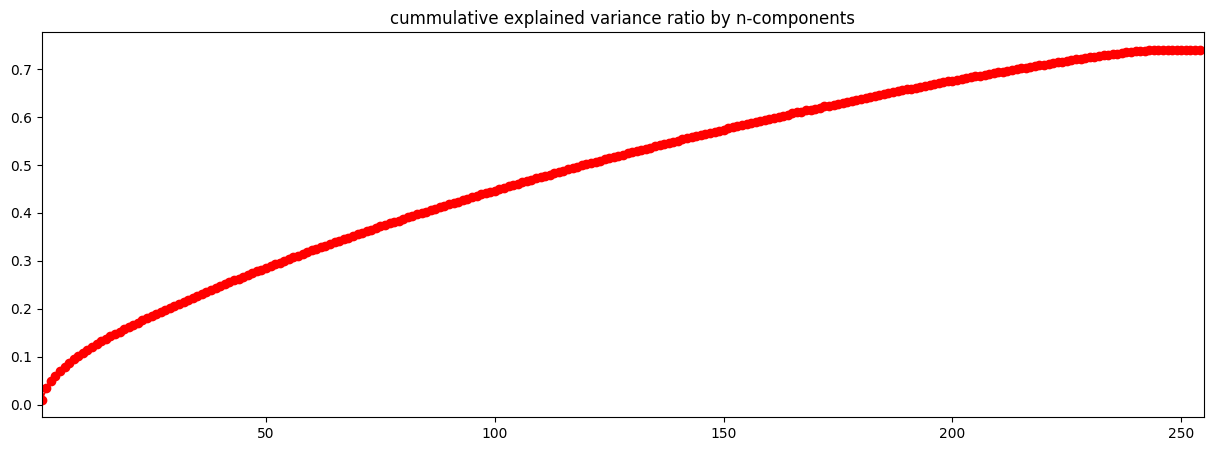

In [16]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('cummulative explained variance ratio by n-components')
plt.xlim(1, 255)


70 to 80% of the explained variance ratio is reached with 125 to 150 topics.

(0.0, 25.0)

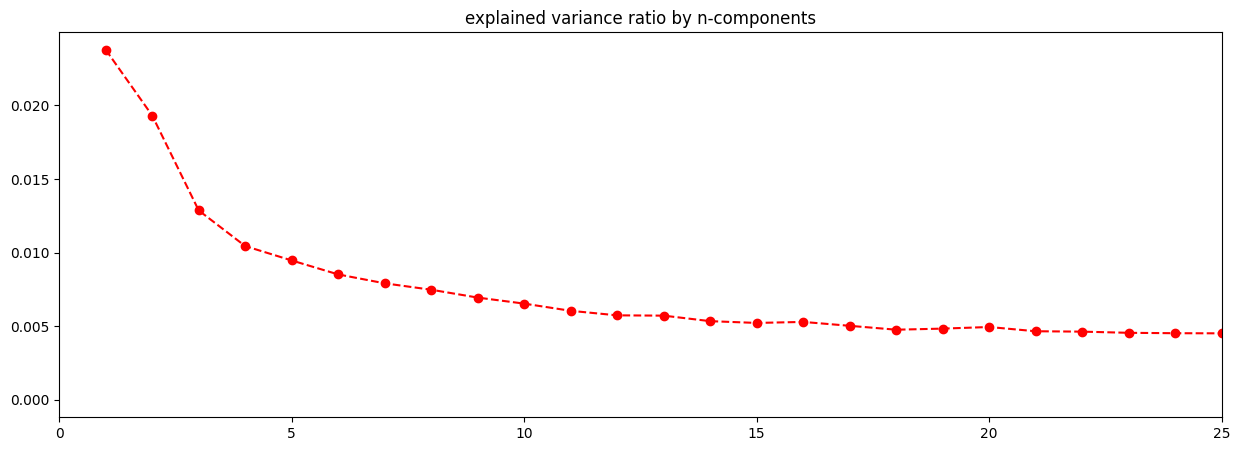

In [17]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test, np.gradient(performance), 'ro--')
plt.title('explained variance ratio by n-components')
plt.xlim(0, 25) # zoom to 25 to see the changes in the first components


The graph shows that the explained variance of the LSA model is about 75% at maximum of 253 topics (= number of documents). This low explained variance is probably due to the relative few but lengthy documents.
The explained variance flattens around 4 topics.

### Determining the beste parameters for the TF-IDF matrix in the LSA context
Below a matrix is constructed for different values of the min_df (absolute values) and max_df (relative values) settings for constructing the TF-IDF matrix. These are evaluated for the total explained variance and the explained variance in the first 5 topics from the LSA. Also the topic composition of the resulting topics are compared.

In [18]:
min_ls = [0, 5, 10, 15, 20, 25, 35, 50]
max_ls = [0.5, 0.75, 0.85, 0.9, 0.95, 1.0]
dimensions = pd.DataFrame(index=min_ls, columns=max_ls)
exvar_tot = pd.DataFrame(index=min_ls, columns=max_ls)
exvar_5 = pd.DataFrame(index=min_ls, columns=max_ls)
words = [[None] * len(max_ls)] * len(min_ls)


In [19]:
i = 0
for min_df in min_ls:
    c = 0
    for max_df in max_ls:
        document_term_matrix, dictionary = \
            compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=min_df, max_df=max_df, sublinear_tf=SUBLINEAR_TF)
        dimensions.loc[min_df, max_df] = dictionary.size
        svd = TruncatedSVD(n_components=255)
        lsa = svd.fit(document_term_matrix)
        exvar_tot.loc[min_df, max_df] = lsa.explained_variance_.sum()
        svd = TruncatedSVD(n_components=5)
        lsa = svd.fit(document_term_matrix)
        exvar_5.loc[min_df, max_df] = lsa.explained_variance_.sum()
        words[i][c] = pd.DataFrame(lsa.components_, columns=dictionary).T
        c += 1
    i += 1


In [20]:
dimensions


,0.50,0.75,0.85,0.90,0.95,1.00
0,64724,65103,65209,65258,65305,65349
5,9492,9871,9977,10026,10073,10117
10,5433,5812,5918,5967,6014,6058
15,3840,4219,4325,4374,4421,4465
20,3001,3380,3486,3535,3582,3626
25,2443,2822,2928,2977,3024,3068
35,1736,2115,2221,2270,2317,2361
50,1111,1490,1596,1645,1692,1736


In [21]:
exvar_tot


,0.50,0.75,0.85,0.90,0.95,1.00
0,0.930351,0.896651,0.881584,0.87237,0.861807,0.84561
5,0.882631,0.832575,0.810544,0.797195,0.781982,0.758837
10,0.854603,0.796406,0.770991,0.755646,0.738215,0.711819
15,0.832383,0.768296,0.740449,0.723682,0.704685,0.675997
20,0.814648,0.746151,0.716505,0.698694,0.678553,0.648218
25,0.798929,0.726655,0.695473,0.676773,0.655667,0.623948
35,0.77057,0.691748,0.657927,0.637706,0.614957,0.580903
50,0.731814,0.644921,0.607854,0.585774,0.561041,0.52422


High total explained variances are achieved for low values of both min_df and max_df. For min_df this is the result of including words that are unique for only a few documents. For max_df it is most likely because the total number of word occurances are reduces, which reduces the total variance.

In [22]:
exvar_5


,0.50,0.75,0.85,0.90,0.95,1.00
0,0.044187,0.045979,0.045691,0.045348,0.044906,0.044266
5,0.059169,0.060062,0.059076,0.058277,0.057178,0.055783
10,0.065904,0.066885,0.065378,0.06424,0.062829,0.061007
15,0.070892,0.071455,0.069529,0.068182,0.066372,0.064179
20,0.074711,0.074812,0.072513,0.070939,0.068859,0.066343
25,0.077463,0.077067,0.074478,0.072719,0.070397,0.067611
35,0.081689,0.080661,0.077333,0.075158,0.072366,0.069021
50,0.08563,0.083503,0.079237,0.076531,0.07311,0.069112


In [23]:
exvar_rel = exvar_5 / exvar_tot
exvar_rel


,0.50,0.75,0.85,0.90,0.95,1.00
0,0.047495,0.051279,0.051829,0.051983,0.052107,0.052348
5,0.067037,0.07214,0.072884,0.073103,0.073119,0.073511
10,0.077116,0.083984,0.084797,0.085014,0.085109,0.085705
15,0.085167,0.093005,0.093901,0.094216,0.094186,0.09494
20,0.09171,0.100264,0.101204,0.10153,0.10148,0.102347
25,0.096958,0.106058,0.10709,0.10745,0.107366,0.10836
35,0.106011,0.116604,0.117541,0.117857,0.117677,0.118817
50,0.117011,0.129478,0.130355,0.130649,0.130312,0.131838


The first five topics explain most of the variance with a high max_df and low min_df. The explained variance ratio is largest at high max_df and high max_df, however this ratio reduces only slightly for medium values of max_df. So the influence of max_df is mainly influenced by the higher total explained variance. The effect of min_df is explained by less unique words for the documents (so the other topics are less able to explain variance).

### Influence of `min_df` and `max_df` on Topic Interpretation
Below the top 20 words in each topic are listed in order to be able to interprete the common theme within the topic. The influence of different min_df and max_df settings can be investegated by changing the index of the words matrix (see matrices above). The defaults are min_df=15 (words[3][-]) and max_df=0.85 (words[-][2]). At these values the resulting topics are labelled as respectively (in Dutch): _duurzaamheid_, _milieu_, _ruimtelijke inrichting_, _beleid and afval/energie_.

In [24]:
topics = ['duurzaamheid', 'milieu', 'ruimtelijke inrichting', 'beleid', 'afval/energie']
topic_matrix = pd.DataFrame(None, index=range(0,20), columns=topics)
for t in range(0,5):
    topic_matrix.iloc[:, t] = words[3][2].sort_values(t, ascending=False)[0:20].index

topic_matrix


,duurzaamheid,milieu,ruimtelijke inrichting,beleid,afval/energie
0,eur,gevaarlijk,ecologisch,eur,restafval
1,afval,geluid,stad,college,zonnepanel
2,maatschappelijk,veiligheid,sociaal,raad,zonnepanelen
3,water,milieubeleidsplan,cradle,samenleving,deal
4,programma,omgevingsvergunning,biodiversiteit,planning,container
5,wij,bodemkwaliteit,verbinding,faciliteren,zonnepane
6,natuur,milieubeleid,leven,budget,dak
7,communicatie,vergunningverlening,people,voorstel,circulair
8,ruimtelijk,sanering,planet,wij,plastic
9,mobiliteit,besluit,voedsel,laadpaal,scheiden


Topic labelling seems quite stable for most options of min_df and max_df. Only values of max_df <= 0.75 the label of the two last topics changes. These two topics seems to have quite a similar theme. It is concluded that low values of max_df results in less intepretable topics.

In [25]:
topics = ['duurzaamheid', 'milieu', 'ruimtelijke inrichting', 'realisatie afval/energie', 'type afval/energie']
topic_matrix = pd.DataFrame(None, index=range(0,20), columns=topics)
for t in range(0,5):
    topic_matrix.iloc[:, t] = words[0][0].sort_values(t, ascending=False)[0:20].index

topic_matrix


,duurzaamheid,milieu,ruimtelijke inrichting,realisatie afval/energie,type afval/energie
0,geluid,gevaarlijk,cradle,energieakkoord,restafval
1,epc,geluid,verbinding,circulair,kwh
2,milieubeleidsplan,omgevingsvergunning,biodiversiteit,laadpaal,windturbine
3,biodiversiteit,milieubeleidsplan,voedsel,restafval,container
4,gpr,bodemkwaliteit,circulair,deal,plastic
5,noord,milieubeleid,recreatie,vastgoed,glas
6,energieakkoord,vergunningverlening,balans,afvalscheiding,gft
7,milieubeleid,sanering,cultuur,omgevingsdienst,verbranden
8,tabel,toezicht,jong,inzamelen,verbranding
9,duurzaamheidsbeleid,saneren,stedelijk,gemeentehuis,huishoudelijk


Topic composition is influenced only slightly by different values of max_df and min_df. Low values of max_df seems to reduce the explainability of the topics.

From this analysis it can be concluded that medium values for both max_df and min_df results in a good balance between total explained variance and the explained variance of the first five topics. For our analysis it is proposed to use min_df = 15 and max_df = 0.85

### Topic assessment with 5 topics
According to the elbow method 5 topics are optimal to assess the information in the documents. Below these 5 topics are assessed for their content and value for clustering.

In [26]:
svd_dv = TruncatedSVD(n_components=5)
lsa_dv = svd_dv.fit(document_term_matrix)
lsa_docs = svd_dv.fit_transform(document_term_matrix)


The first 5 topics only account for 6.6% of the explained variance between the documents.
The first 5 topics are labelled as respectively "duurzaamheid", "milieu", "ecologie", "energie" and "klimaat" according to the most important words in the topic.

In [27]:
topic_names = ["duurzaamheid","milieu","ruimtelijke inrichting","beleid","afval/energie"]
encoded_matrix = pd.DataFrame(lsa_dv.components_, index=topic_names, columns=dictionary).T
encoded_matrix.sort_values("milieu", ascending=False)[0:20] #change the column name to sort by the other topics


,duurzaamheid,milieu,ruimtelijke inrichting,beleid,afval/energie
gevaarlijk,0.020559,0.127131,-0.016116,0.018900,0.002711
geluid,0.028814,0.117631,-0.001807,0.012817,-0.017528
veiligheid,0.034429,0.111211,0.009209,0.017259,-0.014731
milieubeleidsplan,0.027845,0.100414,-0.023750,0.040727,-0.042046
bodemkwaliteit,0.015618,0.098802,-0.018929,0.012111,-0.003277
milieubeleid,0.026487,0.098058,-0.006880,0.017016,-0.019123
omgevingsvergunning,0.017358,0.097888,-0.029520,0.038933,0.012478
vergunningverlening,0.024098,0.094043,-0.052009,0.043030,-0.028247
luchtkwaliteit,0.031937,0.091634,-0.008264,-0.009963,-0.023906
sanering,0.015040,0.090795,-0.017101,0.020745,0.019318


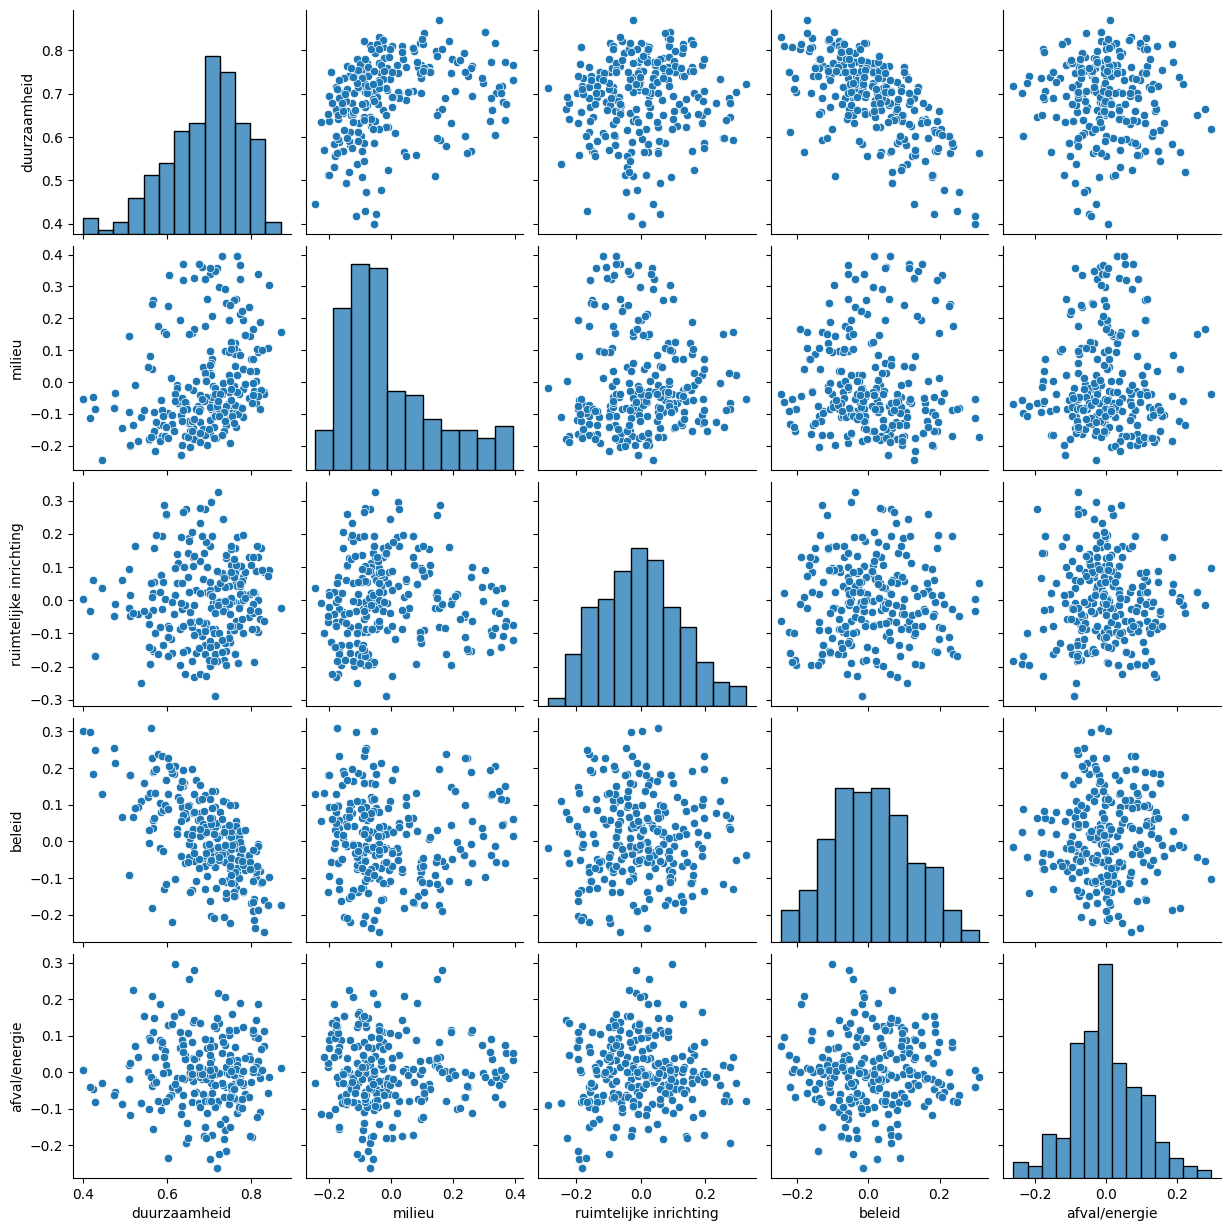

In [28]:
topics_encoded = pd.DataFrame(lsa_docs, columns=topic_names, index=corpus.index)
topics_encoded.to_parquet("../data/Governance/LSA_document_topic_matrix.parquet")
sns.pairplot(topics_encoded)


The first 5 topics don't show direct recognisable clusters. Most documents are pretty low on the 'milieu' topic, which indicates this topic is less mentioned in the sustainability visions. 'Energie' correlates with the first 'duurzaamheid' topic, indicating that most sustainability visions contain energy related terms.